# MOSAIKS: Train and test example for a single task

This notebook provides a simple example of how a new user can leverage the MOSAIKS system to generate predictions of any new outcome. There are three steps:

1) Merge labels (i.e. "ground truth") with corresponding MOSAIKS features, based on location

2) Train the prediction model using ridge regression and k-fold cross-validation

3) Show performance on the validation set of labeled data

Unmodified, this example utilizes labeled tree cover data and satellite imagery features pre-processed using the MOSAIKS system. It is designed to be adaptable for predicting other environmental variables by replacing the tree cover variable with a different variable with minimal changes required. 

## Methodology

The process involves the following steps:

1. **Data Acquisition:** Data for this notebook is the same data used in the original MOSAIKS publication, though it is subset to be a smaller size more suited the free tier of Google Colab. Lables are pre-processed as are satellite imagery features which are derived using the MOSAIKS framework.
1. **Data Preprocessing:** The label and feature data are preprocessed and cleaned. They simply need to be joined before being modeled. Due to the memory restrictions within Colab, we use half of the original observations (*N* = 50,000) and about half of the available features (*K* = 4,000). 
1. **Model Training and Evaluation:** A machine learning model, specifically Ridge Regression,is trained on the combined dataset to predict tree cover percentage. The model's performance is evaluated using the coefficient of determination (R²) metric.
1. **Visualization and Interpretation:** The model results are visualized using maps and plots. 

## Setup

This notebook utilizes several key Python libraries:

* **Data Handling and Analysis:**  `pandas` and `numpy` provide fundamental data structures and functions for manipulating and analyzing data. `geopandas` extends these capabilities to work with geospatial data.
* **Visualization:** `matplotlib.pyplot` and `seaborn` enable the creation of static and interactive visualizations, aiding in data exploration and result presentation.
* **Machine Learning:** `sklearn` offers a comprehensive suite of tools for building and evaluating machine learning models, including algorithms like Ridge Regression and methods for data preprocessing.

In [32]:
import os
import gc
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# from google.colab import drive

from scipy.linalg import LinAlgWarning
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings(
    "ignore", category=LinAlgWarning, module="sklearn.linear_model._ridge"
)

## Download data

This section downloads the sample data, which is stored on Zenodo. It includes the pre-processed satellite imagery features as well as label data for 6 different applications. This data is the same data from the original MOSAIKS publication (Rolf et al., 2021). We use the `wget` utility to download the data from Zenodo. The data comes as a compressed zip file and we use the `unzip` utility to extract the contents.

In [33]:
data_dir = "rolf_et_al_2021_data"

if not os.path.exists(data_dir):
    !wget https://zenodo.org/records/14518415/files/Rolf_et_al_2021_CONT_US_UAR_Data.zip

    !unzip Rolf_et_al_2021_CONT_US_UAR_Data.zip

    !mv Rolf_et_al_2021_CONT_US_UAR_Data {data_dir}

    !rm Rolf_et_al_2021_CONT_US_UAR_Data.zip

!ls -lhR {data_dir}

rolf_et_al_2021_data:
total 17K
drwxr-xr-x 8 cullen_molitor emlab 8 Dec 18 11:37 applications
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:40 features

rolf_et_al_2021_data/applications:
total 291K
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:37 elevation
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:38 income
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:38 nightlights
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:38 population
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:39 roads
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:39 treecover

rolf_et_al_2021_data/applications/elevation:
total 5.5M
-rw-r--r-- 1 cullen_molitor emlab 7.3M Dec 18 10:07 outcomes_sampled_elevation_CONTUS_16_640_UAR_100000_0.csv

rolf_et_al_2021_data/applications/income:
total 1.9M
-rw-r--r-- 1 cullen_molitor emlab 2.7M Dec 18 10:07 outcomes_sampled_income_CONTUS_16_640_UAR_100000_0.csv

rolf_et_al_2021_data/applications/nightlights:
total 4.1M
-rw-r--r-- 1 cullen_molitor emlab 5.1M Dec 18 10:10 outcomes_sam

## Load data

### Task-specific data

Here, the user will need to adjust `label` for their particular context. To run the `treecover` prediction, nothing should need to be updated. If the user is interested in a different task, they will need to update the object `label` to the new task name. Available tasks can be viewed by running the cell below.

In [34]:
!ls {data_dir}/applications

elevation  income  nightlights	population  roads  treecover


Select your task from the list of available tasks and update the `label` object accordingly.

In [35]:
label = "treecover"

labels = pd.read_csv(
    os.path.join(
        data_dir,
        "applications",
        label,
        f"outcomes_sampled_{label}_CONTUS_16_640_UAR_100000_0.csv",
    )
)
labels = labels.drop(
    columns=["Unnamed: 0", "lon", "lat", "V1", "V1.1"], errors="ignore"
)
labels

,ID,treecover
0,"2078,3075",84.829767
1,"2119,3101",24.316364
2,"2145,3104",69.093228
3,"1968,3053",54.553953
4,"2230,3159",30.871985
...,...,...
99995,"913,231",56.053514
99996,"146,252",59.698125
99997,"240,144",90.418367
99998,"979,124",68.462105


### Random convolutional feature data

The random convolutional features extracted from satellite imagery are loaded from a feather file. These features serve as input to the prediction model. The same set of features is used for all tasks.

In [36]:
features = pd.read_feather(
    os.path.join(
        data_dir,
        "features",
        "CONTUS_UAR_4000.feather",
    )
)
features

,lon,lat,ID,X_0,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
0,-82.332989,31.133099,"1825,3099",109.421745,0.002730,1.598002,0.051948,192.028061,0.0,0.042064,...,212.718689,0.019774,427.188171,0.108375,219.264877,0.551875,0.003141,287.808197,245.936935,179.252518
1,-120.937131,45.048654,"534,296",191.471115,0.000494,0.674733,0.033643,325.599121,0.0,0.018419,...,377.188477,0.001119,699.936096,0.068607,360.706421,0.871681,0.000591,450.409790,439.766113,253.609039
2,-101.394042,33.438019,"1627,1715",216.488083,0.000000,1.018798,0.007720,363.550476,0.0,0.012265,...,433.769012,0.002850,790.867004,0.116930,416.635193,0.255052,0.000000,480.654663,521.126648,249.919861
3,-106.090443,45.436509,"494,1374",176.507919,0.000000,1.139586,0.007526,305.683167,0.0,0.010535,...,354.299713,0.001619,717.276184,0.091212,385.545471,0.160233,0.000000,435.593903,441.569458,245.792343
4,-86.010229,44.067430,"634,2832",67.180176,0.012096,0.800398,0.032882,134.503418,0.0,0.033844,...,131.081009,0.026110,388.369141,0.097194,213.896362,0.480515,0.004966,257.275879,176.741394,189.037567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-105.401821,44.589540,"581,1424",188.133865,0.001997,4.124390,0.172895,321.569458,0.0,0.112080,...,373.564240,0.007939,713.957642,0.117884,373.920776,3.448401,0.010491,448.380646,446.624176,250.797180
99996,-110.993431,33.092573,"1657,1018",222.788437,0.000903,3.321170,0.175439,380.871429,0.0,0.043889,...,426.669647,0.001576,771.051392,0.041341,377.991425,2.073433,0.004342,546.509888,461.291199,332.397888
99997,-102.055119,38.903378,"1135,1667",246.027954,0.000077,0.805266,0.016228,412.352112,0.0,0.020553,...,489.502960,0.000432,878.196289,0.081718,457.287811,0.323063,0.000000,546.172119,577.277771,288.189545
99998,-78.848562,42.391924,"801,3352",118.577003,0.003373,1.552520,0.056660,223.619614,0.0,0.032953,...,230.661499,0.007898,580.112000,0.112625,311.864685,0.460987,0.005661,387.947998,289.495636,269.729645


## Step 1: Merge labeled data with features by location

To generalize MOSAIKS across many tasks, we create a standardized grid onto which we project both satellite images and labeled training data. This grid is described in detail in Supplementary Materials Section S.2.1 of Rolf et al. 2021. As described in the Supplementary Materials, satellite images are extracted over the area of each grid cell, and corresponding features are created from each grid cell's imagery. Labeled data are averaged (or summed) over each grid cell.

We sample from this standardized grid in two ways: uniform-at-random (UAR) and population-weighted (POP). We draw 100,000 samples in each case, and the model is trained and all predictions are performed on this random sample. For the tasks presented in this demonstration, the sampling strategy we use is UAR.

Here, we merge satellite image-based features ("X") with labeled data ("Y") based on the location of the grid cell. This location is pre-matched in both datasets and stored in the `ID` column of both datasets. After merging, we are left with a training dataset in which each grid cell has both an outcome ("Y") and a corresponding vector of MOSAIKS features ("X").

To predict a new variable not predicted in the paper, the user will need to calculate grid cell labels from "ground-truth" measurements. These labels can then be merged onto the features. We show examples of how one might calculate these labels in the `code/analysis/label_creation/` section of the original [replication repository](https://github.com/Global-Policy-Lab/mosaiks-paper). 

**Note:** We need to be extremeley aggressive about memory management in this notebook when using the free tier of Google Colab. We will use a subset of the data to avoid running out of memory. We will also use `del <object>` and the `gc` library to manually trigger garbage collection to free up memory.

In [37]:
labels = labels.set_index("ID")
features = features.set_index("ID")
sampled_labels = labels.sample(frac=0.5, random_state=42)
filtered_features = features[features.index.isin(sampled_labels.index)]
merged_df = sampled_labels.join(filtered_features, how="left")

In [ ]:
del labels, features, sampled_labels, filtered_features

import gc

gc.collect()

606

## Step 2: Train MOSAIKS model

We use ridge regression to train a model to predict each outcome variable (i.e. "task") using the same set of MOSAIKS features. 

Within the training/validation sample, we choose the penalization parameter in ridge regression using k-fold cross-validation (here we choose 5 folds). The input vector of penalization parameters (lambdas) are listed in the config.py file (and can be adjusted by the user if desired). In most results, we show performance on the training/validation sample, although the test sample is used just once to assess performance of the trained model for each task (see Supplementary Materials Section S.2.6). Test set and validation set performance are nearly identical for each of the tasks we considered (Table S2). 

### Define `X`'s and `y` for the task

First we must define the columns that contain the features (`X`) and the outcome variable (`y`) for the task. The code below does this for the task of predicting `treecover`. The user will need to update the `label` object (defined above) to the new task name if they are interested in a different task.

In [40]:
feature_cols = [f"X_{i}" for i in range(4000)]

y_var = {"roads": "length", "nightlights": "y"}.get(label, label)

X = merged_df[feature_cols]
y = merged_df[y_var]
c = merged_df[["lon", "lat"]]

In [ ]:
del merged_df
gc.collect()

### Train Test Split

The data is split into a training/validation set and a test set. The training/validation set is used to train the model and tune hyperparameters, while the test set is used to evaluate the model's performance. The split is done randomly, but a `random_state` is set in the `train_test_split` function to ensure we get the same split each time we run the code.

In [41]:
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    X, y, c, test_size=0.2, random_state=42
)

### Train ridge regression model

Our model is a ridge regression model, which is a linear regression model with L2 regularization. The regularization term helps prevent overfitting by penalizing large coefficients. The strength of the regularization is controlled by the `alpha` parameter. We use cross-validation to select the best `alpha` from a predefined list of values.

In [42]:
alphas = np.logspace(-1, 1, base=10, num=3)
ridge = RidgeCV(alphas=alphas, scoring="r2", cv=5)

ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, scoring='r2')

## Step 3: Show performance on the test set

This section evaluates the trained model's performance on the held out test set. First we evaluate the R² values of both the validation set and the test set, as well as the regularization strength (alpha). We then look at a scatter plot of the test set and spatial maps to compare the model's predictions with the actual tree cover labels

In [43]:
y_pred = np.maximum(ridge.predict(X_test), 0)

y_pred = np.minimum(y_pred, 100)

r2 = r2_score(y_test, y_pred)

print(f"Best alpha: {ridge.alpha_}")
print(f"Validation R2 performance {ridge.best_score_:0.2f}")
print(f"Test R2 performance {r2:.4f}")

Best alpha: 1.0
Validation R2 performance 0.88
Test R2 performance 0.8888


### Labeled data versus predictions

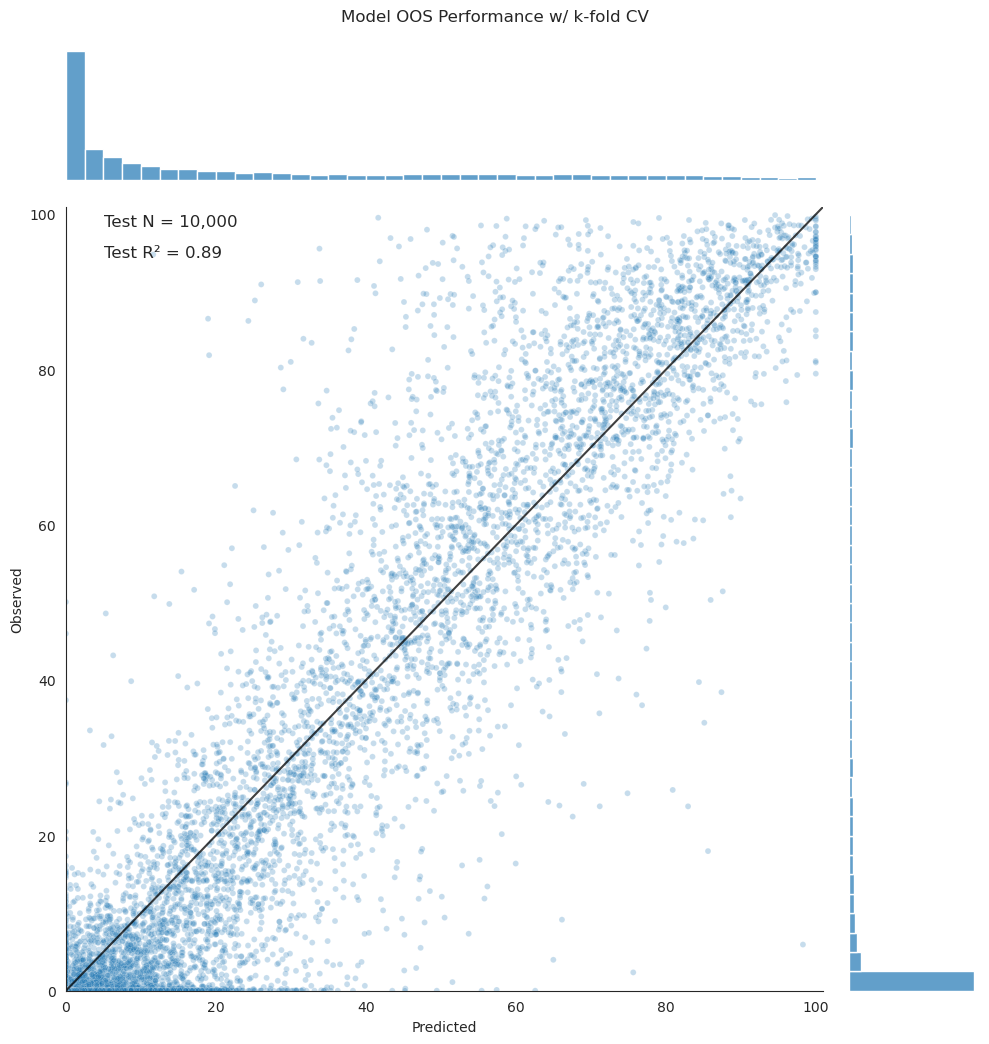

In [45]:
r2 = r2_score(y_test, y_pred)

lims = (0, 101)

with sns.axes_style("white"):
    jg = sns.jointplot(
        x=y_pred,
        y=y_test,
        kind="scatter",
        height=10,
        xlim=lims,
        ylim=lims,
        size=10,
        alpha=0.25,
        legend=False,
        marginal_kws={"bins": 40, "alpha": 0.7},
    )

    # Add the 1:1 line
    jg.ax_joint.plot(lims, lims, "k-", alpha=0.75)

    # Set joint labels
    jg.ax_joint.set_xlabel("Predicted")
    jg.ax_joint.set_ylabel("Observed")

    # Add N text
    jg.ax_joint.text(
        0.05,
        0.99,
        f"Test N = {len(y_test):,}",
        transform=jg.ax_joint.transAxes,
        fontsize=12,
        verticalalignment="top",
    )

    # Add R² text
    jg.ax_joint.text(
        0.05,
        0.95,
        f"Test R² = {r2:.2f}",
        transform=jg.ax_joint.transAxes,
        fontsize=12,
        verticalalignment="top",
    )
    # Title (similar to performance_density)
    plt.suptitle("Model OOS Performance w/ k-fold CV", y=1.02)

    # Remove axis labels and ticks from marginal histograms
    jg.ax_marg_x.set_xlabel("")
    jg.ax_marg_x.set_ylabel("")
    jg.ax_marg_x.tick_params(axis="x", which="both", length=0)
    jg.ax_marg_x.tick_params(axis="y", which="both", length=0)
    jg.ax_marg_y.set_xlabel("")
    jg.ax_marg_y.set_ylabel("")
    jg.ax_marg_y.tick_params(axis="y", which="both", length=0)
    jg.ax_marg_y.tick_params(axis="x", which="both", length=0)

    # Optionally remove the spines around marginal histograms for a cleaner look
    sns.despine(ax=jg.ax_marg_x, left=True, bottom=True)
    sns.despine(ax=jg.ax_marg_y, left=True, bottom=True)

plt.show()


### Spatial distribution of observations and predictions

In [ ]:
c_test_predicted = c_test.copy()
c_test_predicted["label"] = y_test.values
c_test_predicted["prediction"] = y_pred

gdf_test = gpd.GeoDataFrame(
    c_test_predicted,
    geometry=gpd.points_from_xy(c_test_predicted.lon, c_test_predicted.lat),
    crs="EPSG:4326",
)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.01)

vmin = min(gdf_test["label"].min(), gdf_test["prediction"].min())
vmax = max(gdf_test["label"].max(), gdf_test["prediction"].max())

cmap = "viridis"

plot1 = gdf_test.plot(
    column="label",
    ax=axes[0],
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    legend=False,
    markersize=0.75,
    alpha=0.75,
)
axes[0].set_title("Labels")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

plot2 = gdf_test.plot(
    column="prediction",
    ax=axes[1],
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    legend=False,
    markersize=0.75,
    alpha=0.75,
)

axes[1].set_title("Model Predictions")
axes[1].set_xlabel("Longitude")
axes[1].yaxis.set_visible(False)

norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(
    sm,
    ax=axes,
    orientation="horizontal",
    aspect=100,
    pad=0.15,
    location="bottom",
    label=label,
)
plt.show()

## Conclusions

This notebook demonstrated the application of MOSAIKS to predict tree cover (or other variable) using satellite imagery. The model achieved a high R² value on the test set, indicating that it can accurately predict tree cover percentage based on the extracted features. The spatial maps show that the model's predictions closely match the actual tree cover labels, suggesting that the model has learned meaningful patterns from the satellite imagery.

**Key Findings:**  

We found that the model was able to accurately predict tree cover percentage based on the extracted features, achieving an R² value of 0.88 on the test set. This is despite the fact that we are forced to use half of the observations as the original work, and less than half of the satellite features. The spatial maps showed that the model's predictions closely matched the actual tree cover labels, indicating that the model had learned meaningful patterns from the satellite imagery.

**Limitations:**

The model's performance may be artifically inflated due to the quality of the training data. Building similar models with lower quality data (as can be common), may not perform as well. Additionally, the model's performance may be limited by the quality of the satellite imagery. In this case, very high resolution imagery was used, which may not be available in all contexts.